The Jupyter notebook is used to extract the monthly time series of precipitation, air temperature, transpiration, interception, tree cover, and soybean yield for Brazil states.

In [1]:
#############################
####### Load packages ####### 
#############################
# --- numerical computation
import pandas as pd
import numpy  as np
# --- geospatial analysis
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs    
import salem    
# --- scientific plotting
import proplot as pplt # Similar to Matplotlib
import warnings; warnings.filterwarnings("ignore")
import os 

In [2]:
def gridded_area_exact(lats_centr, res, nlon):
    """
    INPUT
        - lats_centr :  latitute of the center [deg N], between -90 to +90 (float or 1D np ary)
        - res :         regular (!) grid resolution [deg]
        - nlon :        to return array of dim (nlat x nlon)

    RETURNS
        - area :        EXACT gridded area, shape as defined by input [km^2] as array of dimension (nlon x nlat)

    ACTION
        based on the grid spacing inferred by lats & lons,
        areas of all grid cells specified by indices and coordinates (lats)
        are computed and summed up in the end.
        Since the spacing between grid cell border longitudes ALWAYS remains
        the same, that is, the resolution in degrees, this function does NOT
        rely on any longitudinal input.

    CAUTION
        1.) this will NOT work properly close to the poles!
        2.) this is based on input coordinates referring to CENTROIDS
        3.) only for regular grids (independent from longitude)
        4.) will produce CRAP if / results in integer division (Python 2.7) !

    NOTES
        - original formula, using degrees (caution -- np.sin requires radian)
            A = (pi/180)R^2 |sin(lat1)-sin(lat2)| |lon1-lon2|
        obtained from:
            pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
    """
    EARTHRADIUS = 6371 # earth radius 
    ## make use of numpy vectorization
    lats1 = (lats_centr+(res/2))*np.pi/180 # np.sin requires radians
    lats2 = (lats_centr-(res/2))*np.pi/180
    areas = (np.pi/180)*(EARTHRADIUS**2)*np.abs(np.sin(lats1)-np.sin(lats2))*res

    ## overwrite any areas of 0 (at the poles) with np.NaN to prevent problems
    try:
        areas[np.where(areas==0.)] = np.NaN # only works for arrays
    except TypeError:
        pass # simply ignore if it's a float
    # return array of dimension nlat x nlon
    ary_area = np.swapaxes(np.tile(areas, (nlon,1)), 0,1)
    return ary_area

#####################################
def makegrid(resolution):
   
    glat     = np.arange(-90,90+resolution,resolution)
    glon     = np.arange(-180,180,resolution)
    gd_area  = gridded_area_exact(glat, res=resolution, nlon=glon.size)
    return glon, glat, gd_area

In [3]:
# read shapefiles of Brazil states
gdf = gpd.read_file('../../../02-src/01-mods/Brazil_states.shp')
gdf = gdf.set_crs(ccrs.PlateCarree().proj4_init)
# index codes
PCODES = gdf['PCODE'].to_list()

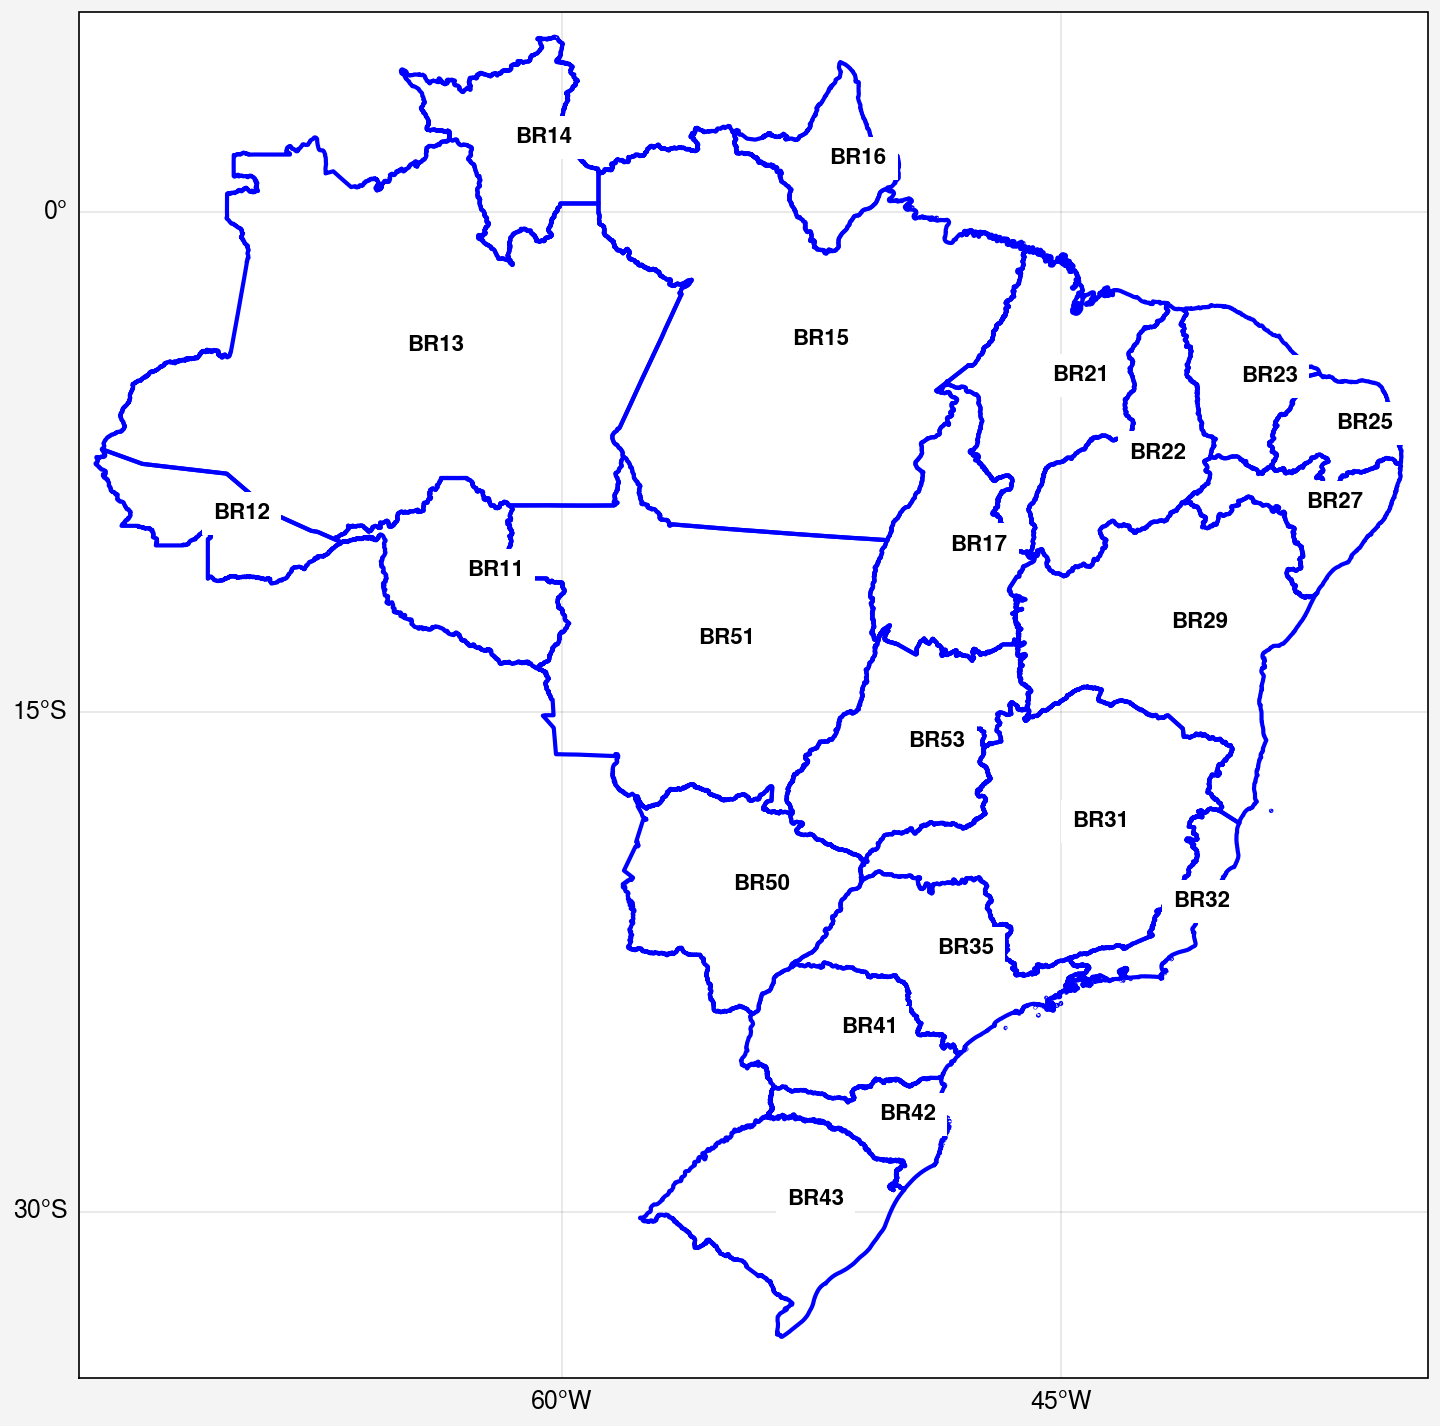

In [4]:
# create the figure
fig, ax = pplt.subplots(refaspect=1, proj='cyl', journal='nat2')
# format the figure
ax.format(
    # grid lines
    gridminor=False, grid=True,
    latlines=15, lonlines=15, labels=True,
    reso='med', lonlim=(-74.5, -34), latlim=(-35, 6))

# plot the GeoDataFrame
gdf.boundary.plot(ax=ax, color='blue')

# add annotations using GeoDataFrame attributes
for idx, row in gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['ADM1_PCODE'], fontsize=8, fontweight='bold', bbox=dict(facecolor='white', alpha=1.0, edgecolor='none'))

fig.save('../../code/results/Brazil_states', dpi=600, bbox_inches='tight')

# Extract the time series of precipitation

In [5]:
################################
# set the time range
start = '1981-01-01'; end = '2018-12-31'
# read the data
ds = xr.open_dataset('../../../01-data/observations/p/P_mswepv2.8_1deg_monthly.nc')
ds = ds['precipitation'].sel(time=slice(start, end))
# extract the data
## set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
## loop & compute
for i in range(len(PCODES)):
    # clip the data
    clip_ds = ds.salem.roi(shape=gdf[gdf['PCODE']== PCODES[i]])
    # calculate the average
    data['BR'+str(PCODES[i])] = clip_ds.mean(axis=(1,2), skipna=True)
# output the data
data.to_csv('../../code/data/rainfall.csv', index=True)

print(data.mean())

BR12    167.681885
BR16    204.844223
BR13    215.469925
BR29     72.553772
BR23     75.664047
BR21    125.650360
BR51    150.961227
BR50    117.296638
BR31    107.685623
BR15    178.683655
BR41    130.488739
BR22     78.425560
BR43    130.675690
BR11    162.889420
BR14    173.707611
BR42    143.539597
BR35    114.975327
BR17    135.685226
BR25     62.075966
BR27     63.851364
BR32     96.832199
BR53    130.923660
dtype: float32


# Extract the time series of air temperature

In [11]:
################################
# set the time range
start = '1981-01-01'; end = '2018-12-31'
# read the data
ds = xr.open_dataset('../../../01-data/Climate/AT/AT_monthly.nc')
ds = ds['AT'].sel(time=slice(start, end))
# extract the data
## set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
## loop & compute
for i in range(len(PCODES)):
    # clip the data
    clip_ds = ds.salem.roi(shape=gdf[gdf['PCODE']== PCODES[i]])
    # calculate the average
    data['BR'+str(PCODES[i])] = clip_ds.mean(axis=(1,2), skipna=True)
# output the data
data.to_csv('../../code/data/temperature.csv', index=True)

print(data.mean())

BR12    25.118801
BR16    26.240219
BR13    26.557254
BR29    23.715827
BR23    26.069755
BR21    26.415006
BR51    25.229396
BR50    24.003066
BR31    21.849263
BR15    26.237577
BR41    19.376185
BR22    26.108753
BR43    18.938476
BR11    25.340649
BR14    26.466310
BR42    17.497761
BR35    21.253050
BR17    25.901126
BR25    25.234223
BR27    23.864699
BR32    22.658062
BR53    23.873750
dtype: float64


# Extract the time series of transpiration of trees

In [12]:
################################
# set the time range
start = '1981-01-01'; end = '2018-12-31'
# read the data
ds = xr.open_dataset('../../../01-data/observations/t_tallveg/T_tallveg_gleam-hybridv3.6_1deg_monthly.nc')

ds = ds['transpiration'].sel(time=slice(start, end))
# extract the data
## set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
## loop & compute
for i in range(len(PCODES)):
    # clip the data
    clip_ds = ds.salem.roi(shape=gdf[gdf['PCODE']== PCODES[i]])
    # calculate the average
    data['BR'+str(PCODES[i])] = clip_ds.mean(axis=(1,2), skipna=True)
# output the data
data.to_csv('../../code/data/transpiration.csv', index=True)

print(data.mean())

BR12    82.422073
BR16    70.135441
BR13    90.965167
BR29    12.761305
BR23     9.342326
BR21    37.082788
BR51    53.638045
BR50    23.143312
BR31    17.963488
BR15    76.928943
BR41    28.117293
BR22    18.288241
BR43    26.525539
BR11    70.657003
BR14    69.180572
BR42    39.293815
BR35    17.777649
BR17    28.226468
BR25     4.273610
BR27     5.577252
BR32    15.628524
BR53    20.383536
dtype: float64


# Extract the time series of interception of trees

In [13]:
################################
# set the time range
start = '1981-01-01'; end = '2018-12-31'
# read the data
ds = xr.open_dataset('../../../01-data/observations/ei/Ei_gleamhybridv36_1deg_monthly.nc')

ds = ds['Ei'].sel(time=slice(start, end))
# extract the data
## set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
## loop & compute
for i in range(len(PCODES)):
    # clip the data
    clip_ds = ds.salem.roi(shape=gdf[gdf['PCODE']== PCODES[i]])
    # calculate the average
    data['BR'+str(PCODES[i])] = clip_ds.mean(axis=(1,2), skipna=True)
# output the data
data.to_csv('../../code/data/interception.csv', index=True)

print(data.mean())

BR12    28.168526
BR16    36.737640
BR13    33.979404
BR29     4.289081
BR23     2.787223
BR21     9.715688
BR51    14.627337
BR50     4.734139
BR31     4.375902
BR15    26.401173
BR41     8.645114
BR22     4.169858
BR43     7.123143
BR11    22.245478
BR14    25.652075
BR42    14.534444
BR35     5.369266
BR17     6.298491
BR25     1.507297
BR27     2.547981
BR32     5.306699
BR53     4.699876
dtype: float32


# Extract the time series of tree cover

In [15]:
################################
# set the time range
start = '1981-01-01'; end = '2018-12-31'
# read the data
ds = xr.open_dataset('../../../01-data/MEASURES/fracT_measuresv60_1deg_monthly.nc')

ds = ds['frac_T'].sel(time=slice(start, end))*100
# extract the data
## set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
## loop & compute
for i in range(len(PCODES)):
    # clip the data
    clip_ds = ds.salem.roi(shape=gdf[gdf['PCODE']== PCODES[i]])
    # calculate the average
    data['BR'+str(PCODES[i])] = clip_ds.mean(axis=(1,2), skipna=True)
# output the data
data.to_csv('../../code/data/tree_cover.csv', index=True)

print(data.mean())

BR12    87.798760
BR16    75.122225
BR13    89.186481
BR29    22.739227
BR23    17.239620
BR21    43.773463
BR51    57.003965
BR50    28.364297
BR31    24.988548
BR15    79.474056
BR41    41.929070
BR22    27.404530
BR43    39.765214
BR11    75.135268
BR14    71.146670
BR42    64.453678
BR35    25.903095
BR17    29.660106
BR25     9.442135
BR27    12.065775
BR32    25.834385
BR53    23.059637
dtype: float64


# Extract the time series of moisture contribution to rainfall


In [8]:
STATES = gdf['ADM1_PCODE'].to_list()
PCODES = gdf['PCODE'].to_list()

agricultural_states = ['BR51', 'BR50', 'BR31', 'BR41', 'BR43', 'BR42', 'BR35', 'BR53']
agricultural_pcodes = [51, 50, 31, 41, 43, 42, 35, 53]

In [9]:
# calculation: Times fraction
mask_states = xr.open_dataset('../../../02-src/01-mods/mask_states_10deg.nc')
mask_states = mask_states['mask']
grid_area   = makegrid(resolution=1.0)[2]

## E2P

In [31]:
# set the time range
start = '1981-01-01'; end = '2018-12-31'

# set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))

for i in range(len(STATES)):
    #! Here, you are calculating the transpiration contribution to rainfall from the entire land. 
    # specift the state
    state = STATES[i]
    pcode = PCODES[i]

    # read the data
    ds =  xr.open_dataset(os.path.join('../../../01-data/HAMSTER', state, 'E2P_EPs_land/HAMSTER_1deg_monthly_E2P_EPs.nc'))
    ds = ds['E2P_EPs'].sel(time=slice(start, end))

    # calculation: Times fraction
    mask_reg = xr.where(mask_states==pcode, 1, np.nan)
    fraction = grid_area/np.nansum(mask_reg*grid_area) 
    ds = ds*fraction # Actual precipitation from the source region

    # calculation of the E2P
    data['BR'+str(PCODES[i])] = np.nansum(ds, axis=(1,2))

print(data.mean())

BR12    167.716333
BR16    204.837719
BR13    215.516422
BR29     72.453559
BR23     75.681975
BR21    125.710091
BR51    151.135889
BR50    117.285780
BR31    107.503902
BR15    178.705565
BR41    130.390872
BR22     78.461877
BR43    130.845453
BR11    162.967454
BR14    173.714437
BR42    143.563866
BR35    114.891861
BR17    135.719303
BR25     62.078111
BR27     63.847363
BR32     96.874214
BR53    130.921838
dtype: float64


Text(0, 0.5, 'Observed P (mm/month)')

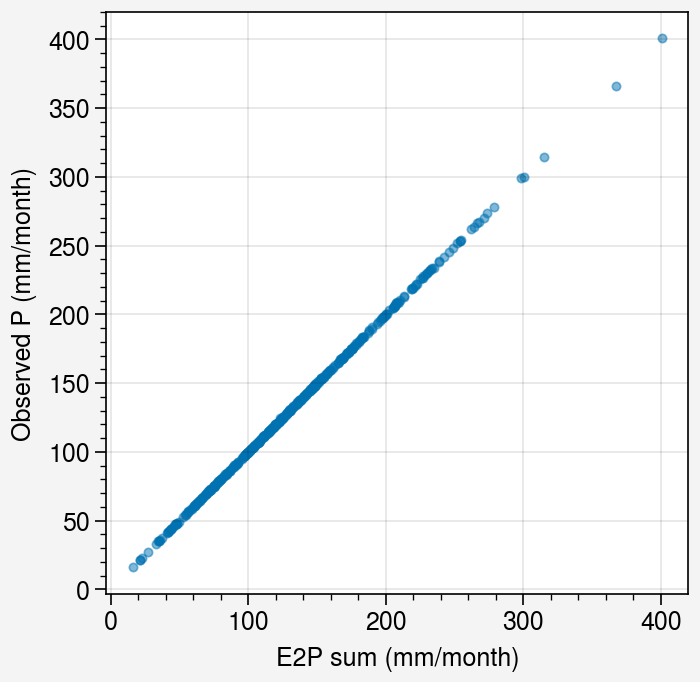

In [34]:
# Here, I will validate the E2P sum and P observations for the region of BR51
prec = pd.read_csv('../../code/data/rainfall.csv', index_col=0)

fig, ax = pplt.subplots(refaspect=1, journal='nat1')
ax.scatter(np.array(data['BR43']), np.array(prec['BR43']), alpha=0.5, marker='.')
ax.set_xlabel('E2P sum (mm/month)')
ax.set_ylabel('Observed P (mm/month)')

## T2P from tall tress

In [35]:
# set the time range
start = '1981-01-01'; end = '2018-12-31'

# set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))

for i in range(len(STATES)):
    #! Here, you are calculating the transpiration contribution to rainfall from the entire land. 
    # specift the state
    state = STATES[i]
    pcode = PCODES[i]

    # read the data
    ds =  xr.open_dataset(os.path.join('../../../01-data/HAMSTER', state, 'T2P_EPs_tall/HAMSTER_1deg_monthly_T2P_EPs.nc'))
    ds = ds['T2P_EPs'].sel(time=slice(start, end))

    # calculation: Times fraction
    mask_reg = xr.where(mask_states==pcode, 1, np.nan)
    fraction = grid_area/np.nansum(mask_reg*grid_area) 
    ds = ds*fraction # Actual precipitation from the source region

    # calculation of the T2P
    data['BR'+str(PCODES[i])] = np.nansum(ds, axis=(1,2))

# output the data
data.to_csv('../../code/data/tree_transpiration_contribution_to_rainfall.csv', index=True)

data.mean().head(5)

BR12     95.980980
BR16     14.121026
BR13    106.601020
BR29      6.897905
BR23      2.410598
dtype: float64


In [ ]:
#! Here, you are calculating the transpiration contribution to rainfall from all states for a specific state. Their sum is approximately equal to the total transpiration contribution to rainfall for the specific region.

# for i in range(len(agricultural_states)):
#     
#     # specift the state
#     state = agricultural_states[i]

#     # set the time range
#     start = '1981-01-01'; end = '2018-12-31'

#     # read the data
#     ds =  xr.open_dataset(os.path.join('../../../01-data/HAMSTER', state, 'T2P_EPs_tall/HAMSTER_1deg_monthly_T2P_EPs.nc'))
#     ds = ds['T2P_EPs'].sel(time=slice(start, end))
#     # extract the data
#     ## set the empty
#     data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
#     ## loop & compute 
#     for i in range(len(PCODES)):
#         # clip the data
#         clip_ds = ds.salem.roi(shape=gdf[gdf['PCODE']== PCODES[i]])
#         # calculate the average
#         data['BR'+str(PCODES[i])] = clip_ds.mean(axis=(1,2), skipna=True)
#     # output the data
#     data.to_csv(os.path.join('../../code/data/tree_transpiration_contribution_to_rainfall_by_states', state+'.csv'), index=True)

## Extract the time series of E2P from oceans and seas

In [36]:
# Masks for land-sea
mask_lsm = xr.open_dataarray('../../code/data/land-sea-mask-1deg.nc')
mask_lsm = mask_lsm[0]
# Masks for Seas
mask_sea = xr.where(mask_lsm<=0, 1, np.nan) 
# Masks for Land
mask_lad = xr.where(mask_lsm> 0, 1, np.nan)

In [38]:
# set the time range
start = '1981-01-01'; end = '2018-12-31'

# set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))

for i in range(len(STATES)):
    #! Here, you are calculating the evaporation contribution to rainfall from the entire land. 
    # specift the state
    state = STATES[i]
    pcode = PCODES[i]

    # read the data
    ds =  xr.open_dataset(os.path.join('../../../01-data/HAMSTER', state, 'E2P_EPs_land/HAMSTER_1deg_monthly_E2P_EPs.nc'))
    ds = ds['E2P_EPs'].sel(time=slice(start, end))

    # calculation: Times fraction
    mask_reg = xr.where(mask_states==pcode, 1, np.nan)
    fraction = grid_area/np.nansum(mask_reg*grid_area) 
    ds = ds*fraction # Actual precipitation from the source region

    # calculation: deforestation pixels
    ds = ds*mask_sea

    # calculation of the T2P
    data['BR'+str(PCODES[i])] = np.nansum(ds, axis=(1,2))

# output the data
data.to_csv('../../code/data/ocean_evaporation_contribution_to_rainfall.csv', index=True)

data.mean().head(5)

BR12     15.310372
BR16    151.468598
BR13     39.731301
BR29     39.743200
BR23     52.348502
dtype: float64

In [39]:
# set the time range
start = '1981-01-01'; end = '2018-12-31'

# set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))

for i in range(len(STATES)):
    #! Here, you are calculating the transpiration contribution to rainfall from the entire land. 
    # specift the state
    state = STATES[i]
    pcode = PCODES[i]

    # read the data
    ds =  xr.open_dataset(os.path.join('../../../01-data/HAMSTER', state, 'E2P_EPs_land/HAMSTER_1deg_monthly_E2P_EPs.nc'))
    ds = ds['E2P_EPs'].sel(time=slice(start, end))

    # calculation: Times fraction
    mask_reg = xr.where(mask_states==pcode, 1, np.nan)
    fraction = grid_area/np.nansum(mask_reg*grid_area) 
    ds = ds*fraction # Actual precipitation from the source region

    # calculation: deforestation pixels
    ds = ds*mask_lad

    # calculation of the T2P
    data['BR'+str(PCODES[i])] = np.nansum(ds, axis=(1,2))

# output the data
data.to_csv('../../code/data/land_evaporation_contribution_to_rainfall.csv', index=True)

data.mean().head(5)

BR12    152.405961
BR16     53.369121
BR13    175.785121
BR29     32.710359
BR23     23.333473
dtype: float64

Text(0, 0.5, 'Observed P (mm/month)')

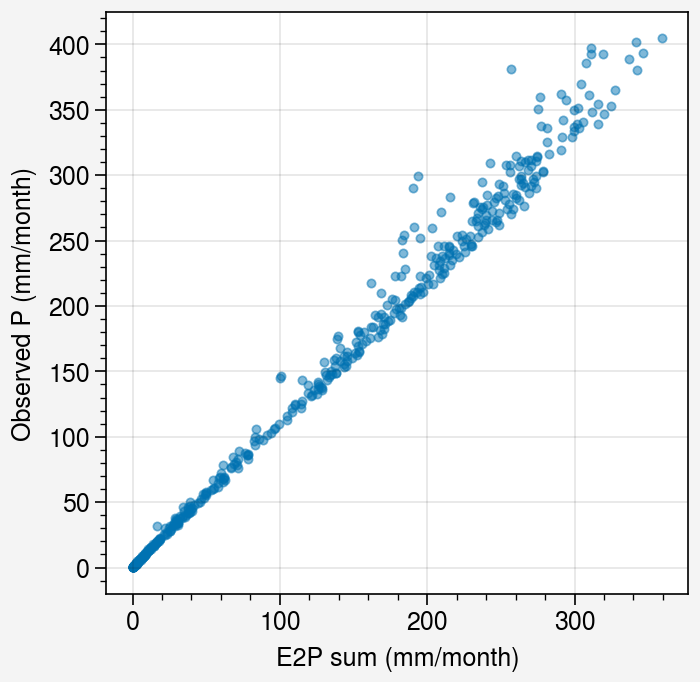

In [51]:
# Here, I will validate the E2P sum and P observations for the region of BR51
prec = pd.read_csv('../../code/data/rainfall.csv', index_col=0)

E2P_sea = pd.read_csv('../../code/data/ocean_evaporation_contribution_to_rainfall.csv', index_col=0)
E2P_lad = pd.read_csv('../../code/data/land_evaporation_contribution_to_rainfall.csv', index_col=0)

fig, ax = pplt.subplots(refaspect=1, journal='nat1')
ax.scatter(data['BR51'], E2P_sea['BR51'] + E2P_lad['BR51'], alpha=0.5, marker='.')

ax.set_xlabel('E2P sum (mm/month)')
ax.set_ylabel('Observed P (mm/month)')

## Extract the time series of T2P from deforestation hotspots

In [52]:
# Deforestation hotspots
mask_deforestation = xr.open_dataarray('../../code/data/deforestation_belt.nc')

In [55]:
# set the time range
start = '1981-01-01'; end = '2018-12-31'

# set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))

for i in range(len(STATES)):
    #! Here, you are calculating the transpiration contribution to rainfall from the entire land. 
    # specift the state
    state = STATES[i]
    pcode = PCODES[i]

    # read the data
    ds =  xr.open_dataset(os.path.join('../../../01-data/HAMSTER', state, 'T2P_EPs_tall/HAMSTER_1deg_monthly_T2P_EPs.nc'))
    ds = ds['T2P_EPs'].sel(time=slice(start, end))

    # calculation: Times fraction
    mask_reg = xr.where(mask_states==pcode, 1, np.nan)
    fraction = grid_area/np.nansum(mask_reg*grid_area) 
    ds = ds*fraction # Actual precipitation from the source region

    # calculation: deforestation pixels
    ds = ds*mask_deforestation

    # calculation of the T2P
    data['BR'+str(PCODES[i])] = np.nansum(ds, axis=(1,2))

# output the data
data.to_csv('../../code/data/hotspots_tree_transpiration_contribution_to_rainfall.csv', index=True)

print(data.mean())

BR12     3.659011
BR16     0.072147
BR13     3.812440
BR29     0.775546
BR23     0.051067
BR21     3.402102
BR51    29.462001
BR50    12.069947
BR31     2.806877
BR15    13.130313
BR41     9.221170
BR22     0.590644
BR43     8.944039
BR11    21.251354
BR14     0.509988
BR42     8.116261
BR35     5.046934
BR17     9.456034
BR25     0.024819
BR27     0.062158
BR32     0.918516
BR53    10.485419
dtype: float64


## Extract the time series of tree evaporation from deforestation hotspots

In [5]:
# Deforestation hotspots
mask_deforestation = xr.open_dataarray('../../code/data/deforestation_belt.nc')

In [8]:
# set the time range
start = '1981-01-01'; end = '2018-12-31'

# set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))

# read the data
TSP = xr.open_dataset('../../../01-data/observations/t_tallveg/T_tallveg_gleam-hybridv3.6_1deg_monthly.nc')
TSP = xr.where(np.isnan(TSP['transpiration']), 0, TSP['transpiration'])
TSP = TSP.sel(time=slice(start, end))
# load data: interception
INT = xr.open_dataset('../../../01-data/observations/ei/Ei_gleamhybridv36_1deg_monthly.nc')
INT = xr.where(np.isnan(INT['Ei']), 0, INT['Ei'])
INT = INT.sel(time=slice(start, end))
# summary TSP and INT
ds = TSP + INT

ds = ds*mask_deforestation # Actual evaporation

data['Tree_evaporation'] = np.nanmean(ds, axis=(1,2))

# output the data
data.to_csv('../../code/data/hotspots_tree_evaporation.csv', index=True)


Tree_evaporation    73.426985
dtype: float64


In [ ]:
#--- Calculate the EVP over the roi
#  set the time range
start = '1981-01-01'; end = '2015-12-31'

# set the empty
ts_EVP_tree_roi = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
    
ds = TSP
ds = ds.sel(time=slice(start, end))

# calculation: Times fraction
mask_reg = xr.where(roi==1, 1, np.nan)

# calculation: deforestation pixels
ds = ds*mask_reg

# calculation of the T2P
ts_EVP_tree_roi['tree_evaporation'] = np.nanmean(ds, axis=(1,2))

# Extract the time series of yield

In [11]:
################################
# set the time range
start = '1982-01-01'; end = '2015-12-31'
# read the data
ds = xr.open_dataset('../../../01-data/GDHY/soybean_major_gdhy_5d_year_1982_2015.nc')
ds = ds['var'].sel(time=slice(start, end))
# extract the data
## set the empty
data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='YS'))
## loop & compute
for i in range(len(PCODES)):
    # clip the data
    clip_ds = ds.salem.roi(shape=gdf[gdf['PCODE']== PCODES[i]])
    # calculate the average
    data['BR'+str(PCODES[i])] = clip_ds.mean(axis=(1,2), skipna=True)
# output the data
data.to_csv('../../code/data/soybean_gdhy.csv', index=True)